In [4]:
import numpy as np
from skimage.segmentation import watershed, felzenszwalb
from skimage.filters import sobel
import pandas as pd
from pathlib import Path
import cv2
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import rank
from scipy import ndimage as ndi
from skimage.morphology import disk
import sklearn.metrics

In [5]:
# downloading the images

# !wget https://challengedata.ens.fr/media/public/train-images.zip
# !wget https://challengedata.ens.fr/media/public/test-images.zip
# !wget https://challengedata.ens.fr/media/public/label_Hnl61pT.csv -O y_train.csv

In [6]:
# !unzip train-images.zip
# !unzip test-images.zip

# Handling the data

In [7]:
# Load the train labels
# Note the transpose!
labels_train = pd.read_csv("./data/y_train.csv", index_col=0).T

In [8]:
# Here is a function to load the data
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

In [9]:
# Load the train and test sets
# If you've put the shortcut directly in your drive, this should work out of the box
# Else, edit the path
data_dir = Path("./data/")
data_train = load_dataset(data_dir / "train-images")
data_test = load_dataset(data_dir / "test-images")

In [21]:
# The train data is a numpy array of 1000 images of 512*512
print(f"X_train shape: {data_train.shape}")
# The train label is a dataframe of 1000 rows with 262144 (=512x512) columns
print(f"Y_train shape: {labels_train.shape}")

# Supposons que Y_train soit un numpy array

zero_rows = np.all(labels_train == 0, axis=1)  # Détecte les lignes avec uniquement des 0
zero_rows_indices = np.where(zero_rows)[0]  # Indices des lignes concernées

print(f"Indices des lignes où toutes les valeurs sont 0: {zero_rows_indices[41:]}")
print(f"Nombre de lignes où toutes les valeurs sont 0: {len(zero_rows_indices)}")
print("Lignes où toutes les valeurs sont 0:")
print(labels_train[zero_rows])

X_train shape: (2000, 256, 256)
Y_train shape: (2000, 65536)
Indices des lignes où toutes les valeurs sont 0: [ 800  801  802 ... 1997 1998 1999]
Nombre de lignes où toutes les valeurs sont 0: 1241
Lignes où toutes les valeurs sont 0:
          Pixel 0  Pixel 1  Pixel 2  Pixel 3  Pixel 4  Pixel 5  Pixel 6  \
5.png           0        0        0        0        0        0        0   
27.png          0        0        0        0        0        0        0   
28.png          0        0        0        0        0        0        0   
45.png          0        0        0        0        0        0        0   
48.png          0        0        0        0        0        0        0   
...           ...      ...      ...      ...      ...      ...      ...   
1995.png        0        0        0        0        0        0        0   
1996.png        0        0        0        0        0        0        0   
1997.png        0        0        0        0        0        0        0   
1998.png       

(array([ 25,  26,  26, ..., 217, 217, 217], shape=(10801,)), array([111, 103, 104, ..., 138, 139, 140], shape=(10801,)))
18


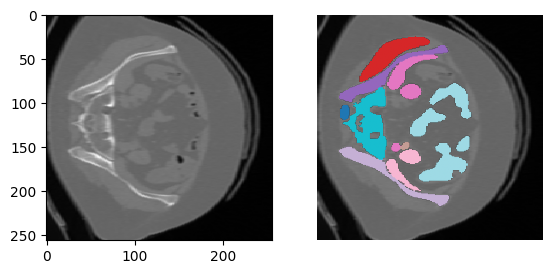

In [11]:
# Let's display some data
# Here is a function to display side by side a slide and a segmented mask
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((256,256)) == 0, (seg.reshape((256,256))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")


print(np.where(labels_train.iloc[0].values.reshape((256,256))!=0))
print(labels_train.iloc[0].values.reshape((256,256))[26,104])
# Let's try it on a slide and ites segmentation mask
# Note: we have to reshape the rows of the dataframe into a 256*256 matrix
plot_slice_seg(data_train[0], labels_train.iloc[0].values.reshape((256,256)))

# Let's compute a baseline

In [12]:
# Let's take a very basic watershed baseline
def compute_baseline_one_sample(data_slice):
    edges = sobel(data_slice)
    denoised = rank.median(data_slice, disk(2))
    markers = rank.gradient(denoised, disk(5)) < 20
    markers = ndi.label(markers)[0]
    label_predicted = watershed(edges, markers=markers, compactness=0.0001)
    return label_predicted

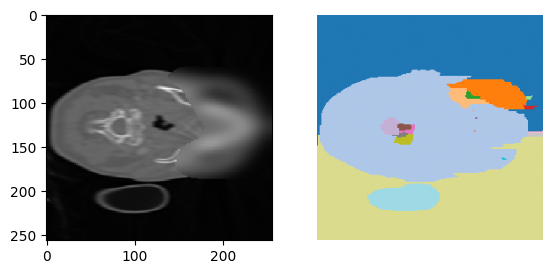

In [13]:
# Let's display the results
# Not too bad!
plot_slice_seg(data_train[2], compute_baseline_one_sample(data_train[2]))

## Let's measure its performances

In [14]:
# Compute the baseline on a whole dataset
def compute_baseline(dataset: np.array):
    labels_predicted_list = []
    for data_index in tqdm(range(len(dataset))):
        data_slice = dataset[data_index]
        label_predicted = compute_baseline_one_sample(data_slice)
        labels_predicted_list.append(label_predicted)
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0).reshape((len(labels_predicted_list), -1)))

In [15]:
# Let's create a validation set first: the 200 first images of the train set
data_val = data_train[:200]
labels_val = labels_train.iloc[:200]

In [16]:
# Compute baseline on a few train data
labels_val_predicted_baseline = compute_baseline(data_val)

100%|██████████| 200/200 [00:03<00:00, 53.07it/s]


In [17]:
NUM_CLASSES = 54 # 55 classes in total, but the first one is the background


def dice_image(prediction, ground_truth):
    intersection = np.sum(prediction * ground_truth)
    if np.sum(prediction) == 0 and np.sum(ground_truth) == 0:
        return np.nan
    return 2 * intersection / (np.sum(prediction) + np.sum(ground_truth))


def dice_multiclass(prediction, ground_truth):
    dices = []
    for i in range(1, NUM_CLASSES + 1): # skip background
        dices.append(dice_image(prediction == i, ground_truth == i))
    return np.array(dices)

def dice_pandas(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    """Compute the dice score for each sample in the dataset and then average it"""
    y_pred_df = y_pred_df.T
    y_true_df = y_true_df.T
    individual_dice = []
    for row_index in range(y_true_df.values.shape[0]):
        dices = dice_multiclass(y_true_df.values[row_index].ravel(), y_pred_df.values[row_index].ravel())
        individual_dice.append(dices)
        # if row_index % 100 == 0:
        #     print("Processes", row_index, "pixels")


    final = np.stack(individual_dice)
    print(final.shape)
    # First, average over images for each class
    # Then, average over classes
    cls_dices = np.nanmean(final, axis=0)
    print(cls_dices.shape)
    return float(np.nanmean(cls_dices))

def dice_pandas2(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    """Compute the dice score for each sample in the dataset and then average it"""
    y_pred_df = y_pred_df.T
    y_true_df = y_true_df.T
    individual_dice = []
    for row_index in range(y_true_df.values.shape[0]):
        dices = dice_multiclass(y_true_df.values[row_index].ravel(), y_pred_df.values[row_index].ravel())
        individual_dice.append(dices)
        print(dices.shape)
        if row_index % 100 == 0:
            print("Processes", row_index, "pixels")

    final = np.stack(individual_dice)
    # First, average over images for each class
    # Then, average over classes
    # cls_dices = np.nanmean(final, axis=0)
    return final



In [18]:
print(labels_val.shape, labels_val_predicted_baseline.shape)
print(labels_val.iloc[100].values[150], labels_val_predicted_baseline.iloc[0].values.reshape((256,256)).shape)

(200, 65536) (200, 65536)
0 (256, 256)


In [19]:
# Compute the metric on the validation set
d1 = dice_pandas2(labels_val[:100], labels_val_predicted_baseline[:100])
print(d1.shape)
d2 = dice_pandas2(labels_val[100:], labels_val_predicted_baseline[100:])
dices = np.concatenate([d1, d2])
print(dices.shape)
print(np.nanmean(dices, axis=0).shape)
dice_score = np.nanmean(np.nanmean(dices, axis=0))
# We get => (0.0011196021617737601); Not so bad, but room for improvements!
# Let's see if you can do better!

(54,)
Processes 0 pixels
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
Processes 100 pixels
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)
(54,)


KeyboardInterrupt: 

In [49]:
print(dice_score)

0.0003900661669533653


In [42]:
print(labels_val.T.values.shape)

(65536, 200)


In [60]:

dice_1 = dice_pandas(labels_val, labels_val_predicted_baseline)

print(dice_1)

(65536, 54)
(54,)
0.0011196021617737601


In [ ]:
a

